In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Fix the seed for reproducible results
tf.random.set_seed(42)

E0000 00:00:1742833815.622841    7398 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742833815.642867    7398 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742833815.777391    7398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742833815.777442    7398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742833815.777444    7398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742833815.777447    7398 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
%matplotlib inline
import sionna
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.phy import mapping
from sionna.phy.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset, AWGN
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import compute_ber, ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector, ResourceGrid
from sionna.phy.mapping import Constellation, Mapper, Demapper
from sionna.phy.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.phy.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.phy.fec.turbo import TurboEncoder, TurboDecoder
from sionna.phy.fec.linear import OSDecoder
from sionna.phy.mapping import BinarySource
from sionna.phy.utils.metrics import  count_block_errors
from sionna.phy.mimo import StreamManagement
import scipy.special as sp
import scipy.stats as stats

# For the implementation of the Keras models
from tensorflow.keras import Model

In [3]:
BATCH_SIZE = 100
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 1

NUM_STREAMS_PER_TX = NUM_UT_ANT

NUM_BITS_PER_SYMBOL = 4
CODERATE = 1

# Number of coded bitsa
n = int(1000)
print(n)
# Number of information bits
k = int(n*CODERATE)
print(k)

1000
1000


In [4]:
awgn_channel = AWGN()
binary_source = BinarySource()

# Create a BPSK constellation with 1 bit per symbol and specify the initial values
constellation = mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

# The mapper maps blocks of information bits to constellation symbols
mapper = mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

# The demapper produces LLR for all coded bits
demapper = mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out = True)

#encoder = sionna.fec.conv.ConvEncoder() # constraint length of the code
#decoder = sionna.fec.conv.ViterbiDecoder() # the code parameters are infered from the encoder

#mapper_1 = sionna.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
#demapper_1 = sionna.mapping.Demapper("app", constellation=constellation)

I0000 00:00:1742833824.906320    7398 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
def generate_noise(no, x):
    """Generates complex AWGN with variance `no`, matching `x`'s shape and dtype.
    
    Args:
        no: Noise variance (float32 tensor/scalar)
        x: Input signal (complex64 tensor)
    
    Returns:
        Complex64 noise tensor with variance `no`
    """
    # Standard deviation for real/imaginary components
    stddev = tf.sqrt(no / 2.0)  # float32

    # Generate real and imaginary parts as float32
    real_part = tf.random.normal(tf.shape(x), stddev=stddev, dtype=tf.float32)
    imag_part = tf.random.normal(tf.shape(x), stddev=stddev, dtype=tf.float32)

    # Combine into complex64 tensor
    noise = tf.complex(real_part, imag_part)
    
    return noise  # dtype: complex64 (matches x)

In [6]:
def impulsive_noise(no, x, mixture_prob=0.6):
    """Generates complex Gaussian mixture noise with two components.
    
    Args:
        no: Base noise variance (float32 scalar/tensor)
        x: Input signal (complex64 tensor) - used to infer shape
        mixture_prob: Probability of selecting the first component (default: 60%)
    
    Returns:
        Complex64 noise tensor with mixture distribution:
        - 60% samples ~ CN(0, 3.4*no)
        - 40% samples ~ CN(0, 2.6*no)
    """
    # Get shape as int32 tensor (required by tf.random.uniform)
    shape = tf.shape(x)  # <-- Correct: Returns int32 tensor
    
    # Component variances
    var1 = 3.4 * no  # Component 1 variance
    var2 = 2.6 * no  # Component 2 variance
    
    # Standard deviations for real/imag parts
    stddev1 = tf.sqrt(var1 / 2.0)
    stddev2 = tf.sqrt(var2 / 2.0)
    
    # Generate mask to select between components
    mask = tf.random.uniform(shape, minval=0.0, maxval=1.0) < mixture_prob
    
    # Generate real and imaginary parts
    real_part = tf.where(
        mask,
        tf.random.normal(shape, stddev=stddev1, dtype=tf.float32),
        tf.random.normal(shape, stddev=stddev2, dtype=tf.float32)
    )
    imag_part = tf.where(
        mask,
        tf.random.normal(shape, stddev=stddev1, dtype=tf.float32),
        tf.random.normal(shape, stddev=stddev2, dtype=tf.float32)
    )
    
    return tf.complex(real_part, imag_part)  # dtype: complex64

In [7]:
bits = binary_source([BATCH_SIZE, NUM_UT, NUM_STREAMS_PER_TX , k])
print(bits)

# The mapper maps blocks of information bits to constellation symbols
x = mapper(bits)
print(x.shape)

no = ebnodb2no(ebno_db=7,
            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
            coderate=CODERATE)
print(no)

y = awgn_channel(x , no)
print(y.shape)

noise = generate_noise(no, x)
y1 = x + noise # Simulate channel output

noise_2 = impulsive_noise(no, x)
y2 = x + noise_2

# The demapper produces LLR for all coded bits
bits_hat = demapper(y , no)
print(bits_hat.shape)

# Theoretical noise power (from `no`)
theoretical_power = no.numpy() if tf.is_tensor(no) else no

# Empirical noise power (from generated noise samples)
empirical_power = tf.reduce_mean(tf.abs(noise_2)**2).numpy()

print(f"Theoretical Noise Power: {theoretical_power:.2e} W")
print(f"Empirical Noise Power: {empirical_power:.2e} W")

# Calculate average signal power of `x`
signal_power = tf.reduce_mean(tf.abs(x)**2).numpy()
print(f"Empirical Signal Power: {signal_power:.4f} W (linear)")

# Convert to dBm for practical interpretation
signal_power_dbm = 10 * np.log10(signal_power) + 30  # 1 W = 30 dBm
print(f"Signal Power: {signal_power_dbm:.2f} dBm")

tf.Tensor(
[[[[1. 1. 0. ... 1. 0. 0.]]]


 [[[0. 0. 1. ... 0. 0. 1.]]]


 [[[1. 0. 0. ... 1. 0. 0.]]]


 ...


 [[[1. 1. 1. ... 0. 1. 1.]]]


 [[[0. 0. 1. ... 0. 0. 0.]]]


 [[[0. 1. 1. ... 1. 1. 1.]]]], shape=(100, 1, 1, 1000), dtype=float32)
(100, 1, 1, 250)
tf.Tensor(0.04988156, shape=(), dtype=float32)
(100, 1, 1, 250)
(100, 1, 1, 1000)
Theoretical Noise Power: 4.99e-02 W
Empirical Noise Power: 1.53e-01 W
Empirical Signal Power: 0.9996 W (linear)
Signal Power: 30.00 dBm


SNR(dB): -3, BER: 0.21163
SNR(dB): -2, BER: 0.18552
SNR(dB): -1, BER: 0.16336
SNR(dB): 0, BER: 0.14080
SNR(dB): 1, BER: 0.11941
SNR(dB): 2, BER: 0.09784
SNR(dB): 3, BER: 0.07834
SNR(dB): 4, BER: 0.05823
SNR(dB): 5, BER: 0.04025
SNR(dB): 6, BER: 0.02831
SNR(dB): 7, BER: 0.01728
SNR(dB): 8, BER: 0.00999
SNR(dB): 9, BER: 0.00426
SNR(dB): 10, BER: 0.00154
SNR(dB): 11, BER: 0.00055
SNR(dB): 12, BER: 0.00015
SNR(dB): 13, BER: 0.00006
SNR(dB): 14, BER: 0.00000
SNR(dB): 15, BER: 0.00000
SNR(dB): 16, BER: 0.00000
SNR(dB): 17, BER: 0.00000
SNR(dB): 18, BER: 0.00000
SNR(dB): 19, BER: 0.00000
SNR(dB): -3, BER: 0.43869
SNR(dB): -2, BER: 0.42887
SNR(dB): -1, BER: 0.41875
SNR(dB): 0, BER: 0.41016
SNR(dB): 1, BER: 0.40090
SNR(dB): 2, BER: 0.38518
SNR(dB): 3, BER: 0.36793
SNR(dB): 4, BER: 0.34952
SNR(dB): 5, BER: 0.32872
SNR(dB): 6, BER: 0.30835
SNR(dB): 7, BER: 0.28117
SNR(dB): 8, BER: 0.25750
SNR(dB): 9, BER: 0.23048
SNR(dB): 10, BER: 0.20718
SNR(dB): 11, BER: 0.18180
SNR(dB): 12, BER: 0.15997
SNR(dB

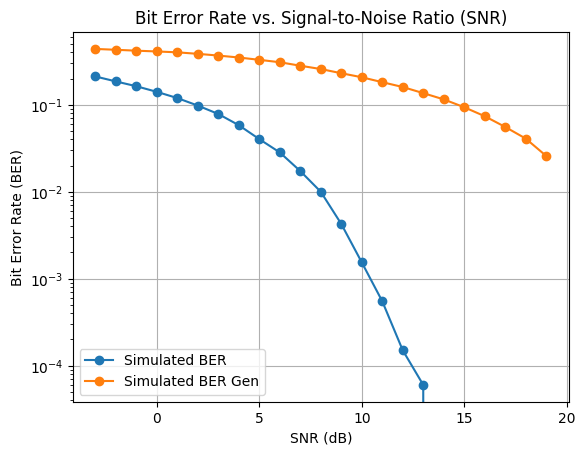

In [8]:
# Define the range of SNRs
snr_range_db = np.arange(-3, 20)  # Range from -3 dB to 10 dB

# Placeholder to store BER values
ber_values = []

for ebno_db in snr_range_db:
    # Convert dB to noise power ratio
    no = ebnodb2no(ebno_db,
        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
        coderate=CODERATE)

    # Transmitter
    y = awgn_channel(x, no)# Simulate channel output
    bits_hat = demapper(y , no)
    ber = compute_ber(bits, bits_hat).numpy()
    print(f"SNR(dB): {ebno_db}, BER: {ber:.5f}")
    ber_values.append(ber)

    
# Placeholder to store BER values
ber_values_gen = []

for ebno_db in snr_range_db:
    # Convert dB to noise power ratio
    no = ebnodb2no(ebno_db,
            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
            coderate=CODERATE)

    # Transmitter
    noise = impulsive_noise(no, x)
    y1 = x + 2.5 * noise # Simulate channel output
    bits_hat = demapper(y1 , no)
    ber = compute_ber(bits, bits_hat).numpy()
    print(f"SNR(dB): {ebno_db}, BER: {ber:.5f}")
    ber_values_gen.append(ber)
    
# Calculate theoretical BER
SNR = 10 ** (snr_range_db / 10)
BER_th = stats.norm.sf(np.sqrt(2 * SNR))

# Plot BER curves
plt.figure()
plt.semilogy(snr_range_db, ber_values, marker='o', label='Simulated BER')
plt.semilogy(snr_range_db, ber_values_gen, marker='o', label='Simulated BER Gen')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('Bit Error Rate vs. Signal-to-Noise Ratio (SNR)')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
class System_Model(tf.keras.Model):
    def __init__(self, k, num_bits_per_symbol):  # FIXED: Add parameters
        super().__init__()
        
        # Store values internally
        self.k = k  # Initialize k
        self.num_bits_per_symbol = num_bits_per_symbol  # Use parameter

        # Initialize components
        self.source = BinarySource()
        self.constellation = Constellation("qam", num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper("app", constellation=self.constellation)

    def generate_awgn(self, x, no):
        """Generates complex AWGN with variance `no` matching the shape/dtype of `x`."""
        stddev = tf.sqrt(no / 2.0)  # Split variance between real/imaginary
        noise_real = tf.random.normal(tf.shape(x), stddev=stddev, dtype=tf.float32)
        noise_imag = tf.random.normal(tf.shape(x), stddev=stddev, dtype=tf.float32)
        return tf.complex(noise_real, noise_imag)

    def generate_impulsive(self, x, no):
        """Generates complex Gaussian mixture noise with two components."""
        shape = tf.shape(x)  # int32 tensor
        
        # Component variances
        var1 = 3.4 * no  # e.g., 3.4 * no
        var2 = 2.6 * no  # e.g., 2.6 * no
        
        # Standard deviations for real/imag parts
        stddev1 = tf.sqrt(var1 / 2.0)
        stddev2 = tf.sqrt(var2 / 2.0)
        
        # Generate mask to select between components
        mask = tf.random.uniform(shape, minval=0.0, maxval=1.0) < 0.6
        
        # Generate real/imag parts
        real_part = tf.where(
            mask,
            tf.random.normal(shape, stddev=stddev1, dtype=tf.float32),
            tf.random.normal(shape, stddev=stddev2, dtype=tf.float32)
        )
        imag_part = tf.where(
            mask,
            tf.random.normal(shape, stddev=stddev1, dtype=tf.float32),
            tf.random.normal(shape, stddev=stddev2, dtype=tf.float32)
        )
        return tf.complex(real_part, imag_part)
    
    @tf.function()
    def call(self, batch_size, ebno_db):
        # Calculate noise variance
        no = ebnodb2no(ebno_db, 
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate= 1)

        # Generate data and encode
        u = self.source([batch_size, 1, 1 , self.k])

        # Map to symbols
        x = self.mapper(u)

        # Generate noise and compute channel output: y = x + n
        n = self.generate_awgn(x, no)  # Explicit noise generation
        y = x + n

        # Demap to LLRs and decode
        u_hat = self.demapper(y, no)

        return u, u_hat

In [10]:
class System_Model_imp(tf.keras.Model):
    def __init__(self, k, num_bits_per_symbol):  # FIXED: Add parameters
        super().__init__()
        
        # Store values internally
        self.k = k  # Initialize k
        self.num_bits_per_symbol = num_bits_per_symbol  # Use parameter

        # Initialize components
        self.source = BinarySource()
        self.constellation = Constellation("qam", num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper("app", constellation=self.constellation)

    def generate_awgn(self, x, no):
        """Generates complex AWGN with variance `no` matching the shape/dtype of `x`."""
        stddev = tf.sqrt(no / 2.0)  # Split variance between real/imaginary
        noise_real = tf.random.normal(tf.shape(x), stddev=stddev, dtype=tf.float32)
        noise_imag = tf.random.normal(tf.shape(x), stddev=stddev, dtype=tf.float32)
        return tf.complex(noise_real, noise_imag)

    def generate_impulsive(self, x, no):
        """Generates complex Gaussian mixture noise with two components."""
        shape = tf.shape(x)  # int32 tensor
        
        # Component variances
        var1 = 3.4 * no  # e.g., 3.4 * no
        var2 = 2.6 * no  # e.g., 2.6 * no
        
        # Standard deviations for real/imag parts
        stddev1 = tf.sqrt(var1 / 2.0)
        stddev2 = tf.sqrt(var2 / 2.0)
        
        # Generate mask to select between components
        mask = tf.random.uniform(shape, minval=0.0, maxval=1.0) < 0.6
        
        # Generate real/imag parts
        real_part = tf.where(
            mask,
            tf.random.normal(shape, stddev=stddev1, dtype=tf.float32),
            tf.random.normal(shape, stddev=stddev2, dtype=tf.float32)
        )
        imag_part = tf.where(
            mask,
            tf.random.normal(shape, stddev=stddev1, dtype=tf.float32),
            tf.random.normal(shape, stddev=stddev2, dtype=tf.float32)
        )
        return tf.complex(real_part, imag_part)
    
    @tf.function()
    def call(self, batch_size, ebno_db):
        # Calculate noise variance
        no = ebnodb2no(ebno_db, 
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate= 1)

        # Generate data and encode
        u = self.source([batch_size, 1, 1 , self.k])

        # Map to symbols
        x = self.mapper(u)

        # Generate noise and compute channel output: y = x + n
        n = self.generate_impulsive(x, no)  # Explicit noise generation
        y = x + 2.5*n

        # Demap to LLRs and decode
        u_hat = self.demapper(y, no)

        return u, u_hat

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.0594e-01 | 1.0000e+00 |        1318 |        6400 |          100 |         100 |         0.7 |reached target block errors
     -2.0 | 1.8906e-01 | 1.0000e+00 |        1210 |        6400 |          100 |         100 |         0.0 |reached target block errors
     -1.0 | 1.6500e-01 | 1.0000e+00 |        1056 |        6400 |          100 |         100 |         0.0 |reached target block errors
      0.0 | 1.4281e-01 | 1.0000e+00 |         914 |        6400 |          100 |         100 |         0.0 |reached target block errors
      1.0 | 1.2250e-01 | 1.0000e+00 |         784 |        6400 |          100 |         100 |         0.0 |reached target block errors
      2.0 | 1.0359e-01 | 1.0000e+00 |         663 |        6400 |

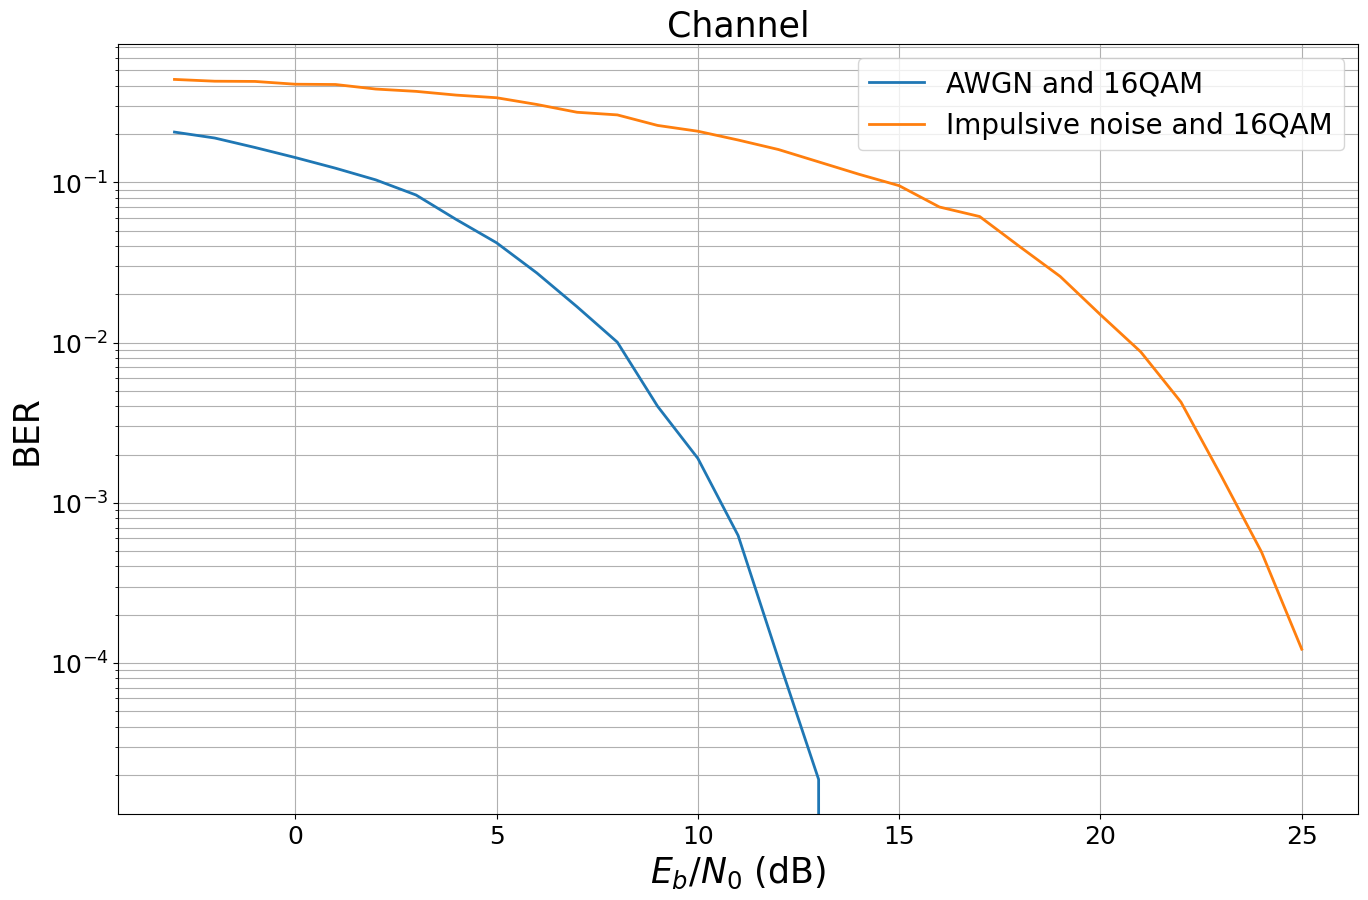

In [11]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 25 # Maximum value of Eb/N0 [dB] for simulations

ber_plots = PlotBER("Channel")

model_ls = System_Model(
    k=64,  # Provide required parameter
    num_bits_per_symbol=4  # Match your constellation
)

ber_plots.simulate(model_ls,
                  ebno_dbs = np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="AWGN and 16QAM",
                  soft_estimates=True,
                  max_mc_iter=50, # run 10 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

model_ls_imp = System_Model_imp(
    k=64,  # Provide required parameter
    num_bits_per_symbol=4  # Match your constellation
)

ber_plots.simulate(model_ls_imp,
                  ebno_dbs = np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Impulsive noise and 16QAM",
                  soft_estimates=True,
                  max_mc_iter=50, # run 10 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);


In [12]:
class System_Model_c(tf.keras.Model):
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,
                 encoder,
                 decoder,
                 demapping_method="app",
                 sim_esno=False,
                 cw_estimates=False):
        super().__init__()

        # Store values internally
        self.k = k
        self.n = n
        self.sim_esno = sim_esno
        self.cw_estimates = cw_estimates
        self.num_bits_per_symbol = num_bits_per_symbol

        # Initialize components
        self.source = BinarySource()
        self.constellation = Constellation("qam", num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method, constellation=self.constellation)
        self.encoder = encoder
        self.decoder = decoder

    def generate_awgn(self, x, no):
        """Generates complex AWGN with variance `no` matching the shape/dtype of `x`."""
        stddev = tf.sqrt(no / 2.0)  # Split variance between real/imaginary
        noise_real = tf.random.normal(tf.shape(x), stddev=stddev, dtype=tf.float32)
        noise_imag = tf.random.normal(tf.shape(x), stddev=stddev, dtype=tf.float32)
        return tf.complex(noise_real, noise_imag)

    def generate_impulsive(self, x, no):
        """Generates complex Gaussian mixture noise with two components."""
        shape = tf.shape(x)  # int32 tensor
        
        # Component variances
        var1 = 3.4 * no  # e.g., 3.4 * no
        var2 = 2.6 * no  # e.g., 2.6 * no
        
        # Standard deviations for real/imag parts
        stddev1 = tf.sqrt(var1 / 2.0)
        stddev2 = tf.sqrt(var2 / 2.0)
        
        # Generate mask to select between components
        mask = tf.random.uniform(shape, minval=0.0, maxval=1.0) < 0.6
        
        # Generate real/imag parts
        real_part = tf.where(
            mask,
            tf.random.normal(shape, stddev=stddev1, dtype=tf.float32),
            tf.random.normal(shape, stddev=stddev2, dtype=tf.float32)
        )
        imag_part = tf.where(
            mask,
            tf.random.normal(shape, stddev=stddev1, dtype=tf.float32),
            tf.random.normal(shape, stddev=stddev2, dtype=tf.float32)
        )
        return tf.complex(real_part, imag_part)
    
    @tf.function()
    def call(self, batch_size, ebno_db):
        # Calculate noise variance
        if self.sim_esno:
            no = ebnodb2no(ebno_db, num_bits_per_symbol=1, coderate=1)
        else:
            no = ebnodb2no(ebno_db, 
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=self.k/self.n)

        # Generate data and encode
        u = self.source([batch_size, NUM_UT, NUM_STREAMS_PER_TX , self.k])
        c = self.encoder(u)

        # Map to symbols
        x = self.mapper(c)

        # Generate noise and compute channel output: y = x + n
        n = self.generate_impulsive(x, no)  # Explicit noise generation
        y = x + 2.5*n

        # Demap to LLRs and decode
        llr_ch = self.demapper(y, no)
        u_hat = self.decoder(llr_ch)

        if self.cw_estimates:
            return c, u_hat
        return u, u_hat

In [13]:
# code parameters
k = 64 # number of information bits per codeword
n = 128 # desired codeword length

# Create list of encoder/decoder pairs to be analyzed.
# This allows automated evaluation of the whole list later.
codes_under_test = []

# 5G LDPC codes with 20 BP iterations
enc = LDPC5GEncoder(k=k, n=n)
dec = LDPC5GDecoder(enc, num_iter=20)
name = "5G LDPC BP-20"
codes_under_test.append([enc, dec, name])

# Polar Codes (SC decoding)
enc = Polar5GEncoder(k=k, n=n)
dec = Polar5GDecoder(enc, dec_type="SC")
name = "5G Polar+CRC SC"
codes_under_test.append([enc, dec, name])

# Polar Codes (SCL decoding) with list size 8.
# The CRC is automatically added by the layer.
enc = Polar5GEncoder(k=k, n=n)
dec = Polar5GDecoder(enc, dec_type="SCL", list_size=8)
name = "5G Polar+CRC SCL-8"
codes_under_test.append([enc, dec, name])

### non-5G coding schemes

# RM codes with SCL decoding
f,_,_,_,_ = generate_rm_code(3,7) # equals k=64 and n=128 code
enc = PolarEncoder(f, n)
dec = PolarSCLDecoder(f, n, list_size=8)
name = "Reed Muller (RM) SCL-8"
codes_under_test.append([enc, dec, name])

# Conv. code with Viterbi decoding
enc = ConvEncoder(rate=1/2, constraint_length=8)
dec = ViterbiDecoder(gen_poly=enc.gen_poly, method="soft_llr")
name = "Conv. Code Viterbi (constraint length 8)"
codes_under_test.append([enc, dec, name])

# Turbo. codes
enc = TurboEncoder(rate=1/2, constraint_length=4, terminate=False) # no termination used due to the rate loss
dec = TurboDecoder(enc, num_iter=8)
name = "Turbo Code (constraint length 4)"
codes_under_test.append([enc, dec, name])


Running: 5G LDPC BP-20
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 4.6344e-01 | 1.0000e+00 |        2966 |        6400 |          100 |         100 |         3.2 |reached target block errors
     -2.0 | 4.6609e-01 | 1.0000e+00 |        2983 |        6400 |          100 |         100 |         0.0 |reached target block errors
     -1.0 | 4.4422e-01 | 1.0000e+00 |        2843 |        6400 |          100 |         100 |         0.0 |reached target block errors
      0.0 | 4.5203e-01 | 1.0000e+00 |        2893 |        6400 |          100 |         100 |         0.0 |reached target block errors
      1.0 | 4.6875e-01 | 1.0000e+00 |        3000 |        6400 |          100 |         100 |         0.0 |reached target block errors
      2.0 | 4.5391e-01 | 1.0000e+00 |    

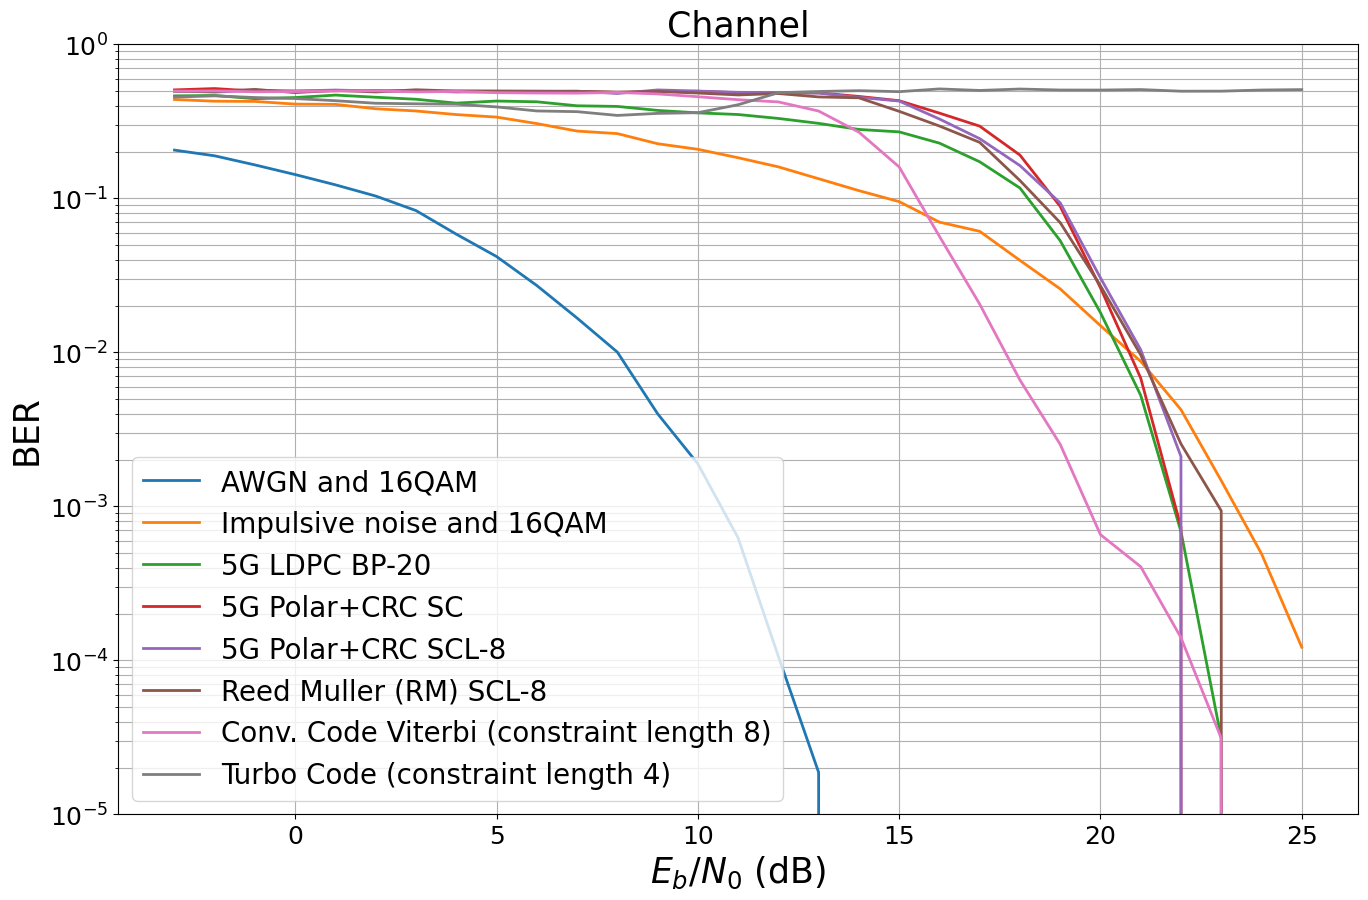

In [14]:
# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\nRunning: " + code[2])

    
    # generate a new model with the given encoder/decoder
    model = System_Model_c(k=k,
                         n=n,
                         num_bits_per_symbol=4,
                         encoder=code[0],
                         decoder=code[1])

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plots.simulate(model, # the function have defined previously
                    ebno_dbs=np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1), # SNR to simulate
                    legend=code[2], # legend string for plotting
                    max_mc_iter=10, # run 100 Monte Carlo runs per SNR point
                    num_target_block_errors=100, # continue with next SNR point after 1000 bit errors
                    batch_size=BATCH_SIZE, # batch-size per Monte Carlo run
                    soft_estimates=False, # the model returns hard-estimates
                    early_stop=True, # stop simulation if no error has been detected at current SNR point
                    show_fig=False, # we show the figure after all results are simulated
                    add_bler=True, # in case BLER is also interesting
                    forward_keyboard_interrupt=True); # should be True in a loop

# and show the figure
ber_plots(ylim=(1e-5, 1), show_bler=False) # we set the ylim to 1e-5 as otherwise more extensive simulations would be required for accurate curves.


In [15]:
class System_Model(tf.keras.Model):
    def __init__(self, k, n, num_bits_per_symbol, encoder, decoder, demapping_method="app"):
        super().__init__()
        self.k = k          # Information bits per codeword (64)
        self.n = n          # Codeword length (128)
        self.num_bits_per_symbol = num_bits_per_symbol
        self.encoder = encoder  # ReedSolomonEncoder instance
        self.decoder = decoder  # ReedSolomonDecoder instance
        self.demapping_method = demapping_method

        # Sionna components
        self.source = BinarySource()
        self.constellation = Constellation("qam", num_bits_per_symbol=num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method, constellation=self.constellation)

    def call(self, inputs):
        """
        Forward pass of the system model.
        
        Args:
            inputs (dict): Contains keys "batch_size" and "ebno_db".
        
        Returns:
            u (tf.Tensor): Original messages (shape [batch_size, 1, 1, k]).
            u_hat (tf.Tensor): Decoded messages (shape [batch_size, 1, 1, k]).
        """
        batch_size = inputs["batch_size"]
        ebno_db = inputs["ebno_db"]

        # Generate random bits: shape [batch_size, 1, 1, k]
        u = self.source([batch_size, 1, 1, self.k])

        # Encode using Reed-Solomon
        u_flat = tf.reshape(u, [batch_size, -1]).numpy()  # Flatten to [batch_size, k]
        c = np.array([self.encoder.encode(msg) for msg in u_flat])  # Encode each message
        c = tf.convert_to_tensor(c, dtype=tf.float32)  # [batch_size, n]

        # Map to symbols
        x = self.mapper(c)  # [batch_size, n/m] (since n=128 and m=8, 16 symbols)

        # Calculate noise variance
        no = ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.k/self.n)
        noise = tf.random.normal(tf.shape(x), stddev=tf.sqrt(no/2))
        y = x + noise  # Add AWGN

        # Demap to LLRs
        llr = self.demapper([y, no])  # [batch_size, n]

        # Decode using Reed-Solomon
        u_hat = []
        for i in range(batch_size):
            # Convert LLRs to hard bits
            hard_bits = tf.cast(llr[i] < 0, tf.float32).numpy()
            # Decode
            decoded = self.decoder.decode(hard_bits)
            u_hat.append(decoded)
        u_hat = tf.convert_to_tensor(u_hat, dtype=tf.float32)  # [batch_size, k]

        return u, tf.reshape(u_hat, [batch_size, 1, 1, self.k])

In [16]:
# Reed-Solomon components
rs_encoder = ReedSolomonEncoder(n=16, k=8, m=8)  # n_symbols=16, k_symbols=8
rs_decoder = ReedSolomonDecoder(n=16, k=8, m=8)

# System model with RS code
model = System_Model(
    k=64, 
    n=128, 
    num_bits_per_symbol=4,  # 16-QAM
    encoder=rs_encoder,
    decoder=rs_decoder
)

NameError: name 'ReedSolomonEncoder' is not defined

In [ ]:
# Simulate the model
EBN0_DB_MIN = -3.0
EBN0_DB_MAX = 25
BATCH_SIZE = 100

ber_plots = PlotBER("Reed-Solomon (64, 128) with 16-QAM")

ber_plots.simulate(
    model,
    ebno_dbs=np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1),
    batch_size=BATCH_SIZE,
    num_target_block_errors=100,
    legend="RS (64,128) + 16-QAM",
    soft_estimates=False,  # RS uses hard decision decoding
    max_mc_iter=50,
    show_fig=False
)

ber_plots(ylim=(1e-5, 1), show_bler=False)
ebno_db = 5.0  # Example Eb/No value

# Forward pass
u, u_hat = model(batch_size, ebno_db)

# Compare original and decoded messages
if tf.reduce_all(u == u_hat):
    print("Success: Decoded messages match the original!")
else:
    print("Failure: Decoded messages do not match the original.")